In [1]:
%matplotlib inline

In [3]:
import math
import random
import skimage.io as io
import matplotlib.pyplot as plt
import keras
import pickle
import numpy as np
# import cv2
import os
from os import listdir
from os.path import isfile, join
import sys
# import dlib
# import skvideo.io
import json
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import glob
import re
from collections import defaultdict

import nltk
from nltk.corpus import cmudict
import tensorflow as tf

In [3]:
# os.environ['CUDA_VISIBLE_DEVICES']='2'

# Prepare Data

## Phonemes

In [4]:
phoneme_list = [] 
phoneme_dict = {}

with open("/n/fs/scratch/jiaqis/cmudict-master/cmudict.phones", 'r') as fp:
    i = 0
    line = fp.readline()
    while line:
        phoneme = line.split()[0].strip()
        phoneme_property = line.split()[1].strip()
        phoneme_list.append((phoneme, phoneme_property))
        phoneme_dict[phoneme] = i
        line = fp.readline()
        i=i+1

print(phoneme_list, phoneme_dict)

([('AA', 'vowel'), ('AE', 'vowel'), ('AH', 'vowel'), ('AO', 'vowel'), ('AW', 'vowel'), ('AY', 'vowel'), ('B', 'stop'), ('CH', 'affricate'), ('D', 'stop'), ('DH', 'fricative'), ('EH', 'vowel'), ('ER', 'vowel'), ('EY', 'vowel'), ('F', 'fricative'), ('G', 'stop'), ('HH', 'aspirate'), ('IH', 'vowel'), ('IY', 'vowel'), ('JH', 'affricate'), ('K', 'stop'), ('L', 'liquid'), ('M', 'nasal'), ('N', 'nasal'), ('NG', 'nasal'), ('OW', 'vowel'), ('OY', 'vowel'), ('P', 'stop'), ('R', 'liquid'), ('S', 'fricative'), ('SH', 'fricative'), ('T', 'stop'), ('TH', 'fricative'), ('UH', 'vowel'), ('UW', 'vowel'), ('V', 'fricative'), ('W', 'semivowel'), ('Y', 'semivowel'), ('Z', 'fricative'), ('ZH', 'fricative')], {'IY': 17, 'W': 35, 'DH': 9, 'Y': 36, 'HH': 15, 'CH': 7, 'JH': 18, 'ZH': 38, 'EH': 10, 'NG': 23, 'TH': 31, 'AA': 0, 'B': 6, 'AE': 1, 'D': 8, 'G': 14, 'F': 13, 'AH': 2, 'K': 19, 'M': 21, 'L': 20, 'AO': 3, 'N': 22, 'IH': 16, 'S': 28, 'R': 27, 'EY': 12, 'T': 30, 'AW': 4, 'V': 34, 'AY': 5, 'Z': 37, 'ER': 1

In [5]:
pron_dict = cmudict.dict()

In [6]:
def clean_pron(pron):
    """Remove stress from pronunciations."""
    return re.sub(r"\d", "", pron)

def make_triphones(pron):
    """Output triphones from a word's pronunciation."""
    if len(pron) < 3:
        return []
    # Junk on end is to make word boundaries work
    return ([((pron[idx - 2], pron[idx - 1]), pron[idx])
             for idx in range(2, len(pron))] + [(('#', '#'), pron[0])] +
            [((pron[-2], pron[-1]), '#')])
                                                
def triphone_probs(prons):
    """Calculate triphone probabilities for pronunciations."""
    context_counts = defaultdict(lambda: defaultdict(int))
    for pron in prons:
        for (context, phoneme) in make_triphones(pron):
            context_counts[context][phoneme] += 1
            
    for (context, outcomes) in context_counts.items():
        total_outcomes = sum(outcomes.values())
        for outcome, count in outcomes.items():
            context_counts[context][outcome] = float(count) / total_outcomes
        
    return context_counts

## Video Volume and Facial Features

In [7]:
DATA_DIR = "/n/fs/scratch/jiaqis/LRS3-TED/"
SAVE_DIR = "/n/fs/scratch/jiaqis/LRS3-TED-Extracted/"

In [41]:
frame_limit = 80
def get_dataset_list(dataDir, setName):
    # Images, facial/mouth features, text-> phonetic
    data_list = []
    for urlDir in glob.glob(os.path.join(dataDir, setName, "*/")):
        url = urlDir.split('/')[-2]
        for idFilename in glob.glob(os.path.join(urlDir, '*.txt')):
            index = idFilename.split('/')[-1].split('.')[0]
            filepath = os.path.join(dataDir, setName, url, index)
            
            text = open(filepath+".txt", 'r').readline()
            words = text[5:].lower().strip().split()
            flag = False
            for word in words:
                if word not in pron_dict:
                    flag=True
                    break
            if flag:
                continue
            imgfiles = sorted(glob.glob(filepath + "_*.jpg"))
            if len(imgfiles) > frame_limit:
                continue
            
            ID = idFilename.split('/')[-1].split('.')[0]
            data_list.append((url, ID))
    return data_list

In [42]:
test_ID_list = get_dataset_list(SAVE_DIR, "test")

In [43]:
trainval_ID_list = get_dataset_list(SAVE_DIR, "trainval")

In [45]:
json.dump(test_ID_list, open('test_ID_list_'+str(frame_limit)+'.json', "w"))

In [46]:
json.dump(trainval_ID_list, open('trainval_ID_list_'+str(frame_limit)+'.json', "w"))

In [14]:
test_ID_list = json.load(open('test_ID_list.json', "r"))
trainval_ID_list = json.load(open('trainval_ID_list.json', "r"))

In [44]:
print(len(test_ID_list), len(trainval_ID_list))

(508, 6231)


# Data Loader

In [9]:
FPS = 25
FRAME_ROWS = 120
FRAME_COLS = 120
NFRAMES = 5 # size of input volume of frames
MARGIN = NFRAMES/2
COLORS = 1 # grayscale
CHANNELS = COLORS*NFRAMES
MAX_FRAMES_COUNT= 250 # corresponding to 10 seconds, 25Hz*10

EXAMPLE_FILEPATH = "/n/fs/scratch/jiaqis/LRS3-TED-Extracted/test/0Fi83BHQsMA/00002"

In [10]:
video_tensor_size = (100, 224, 224, 3) 
keypoint_size=20
label_seq_size=100
n_classes=39

In [11]:
def prepare_data(filepath, img_size, keypoint_size, label_seq_size):
    # images
    # frames x rows x cols x channels
    visual_cube = []
    # keypoint features
    feature_cube = []
    features = json.load(open(filepath + ".json", 'r'))
    # Target Text/phonemes
    labels = []
    text = open(filepath+".txt", 'r').readline()
    words = text[5:].lower().strip().split()
    for word in words:
        word_phonemes = pron_dict[word][0]
        word_indices = [phoneme_dict[clean_pron(phon)] for phon in word_phonemes]
        labels.extend(word_indices)
            
    acc = 0
    for imgFilename in sorted(glob.glob(filepath + "_*.jpg")):
        if 'mouth' in imgFilename:
            continue
        x = image.img_to_array(
              image.load_img(imgFilename, target_size=img_size))/255.0
#         x = np.expand_dims(x, axis=0)
#         x = preprocess_input(x)
        visual_cube.append(x)
        
        mask = np.zeros((img_size[0], img_size[1], keypoint_size))
        framenum = str(int(imgFilename.split("_")[-1].split(".")[0]))
        f_feature = features[framenum]['mouthCoords']
        for ft_index in range(keypoint_size):
            # TODO: check range of outputs
            keypoint_x = f_feature[ft_index][0] - 1
            keypoint_y = f_feature[ft_index][1] - 1
            mask[keypoint_y, keypoint_x, ft_index] = 1.0
        feature_cube.append(mask)
        acc+=1
    return np.array(visual_cube), np.array(feature_cube), np.array(labels)

In [12]:
visual_cube, feature_cube, labels = prepare_data(EXAMPLE_FILEPATH, (224, 224, 3), 20, 100)

In [13]:
print(visual_cube[:, :, :, :].shape)
print(feature_cube.shape)
print(labels.shape)

(41, 224, 224, 3)
(41, 224, 224, 20)
(19,)


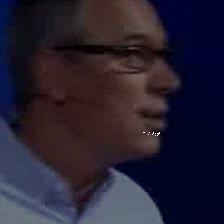

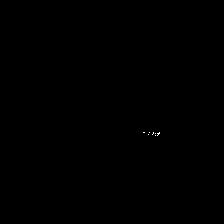

In [22]:
## TODO: Not working
import PIL.Image
from cStringIO import StringIO
import IPython.display
import numpy as np
def showarray(a, fmt='jpeg'):
    a = np.uint8(a * 255.0)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

sub_cube = np.sum(feature_cube[0, :, :, :], axis=-1)
mix_cube = np.minimum((visual_cube[0, :, :, :]) * 0.5
                + np.sum(feature_cube[0, :, :, :], axis=-1, keepdims=True), 1.0)
showarray(mix_cube)
showarray(sub_cube)

In [ ]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_dir, subset, list_IDs, prons, phonemes,
                       video_tensor_size=(200, 224, 224, 3), keypoint_size=20, label_seq_size=90, 
                       batch_size=32,
                       n_classes=39, shuffle=True):
        'Initialization'
        self.data_dir = data_dir
        self.subset = subset
        self.video_tensor_size = video_tensor_size
        self.img_size = (video_tensor_size[1], video_tensor_size[2], video_tensor_size[3])
        self.keypoint_size =keypoint_size
        self.label_seq_size = label_seq_size
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.prons = prons
        self.phonemes = phonemes
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(float(len(self.list_IDs)) / float(self.batch_size)))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, Y = self.data_generation(list_IDs_temp)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        V = np.zeros((len(list_IDs_temp), 
                      self.video_tensor_size[0],
                      self.video_tensor_size[1],
                      self.video_tensor_size[2],
                      self.video_tensor_size[3]))
        F = np.zeros((len(list_IDs_temp), 
                      self.video_tensor_size[0], 
                      self.video_tensor_size[1],
                      self.video_tensor_size[2],
                      self.keypoint_size))
        # null = self.n_classes
        T = self.n_classes * np.ones((len(list_IDs_temp), self.label_seq_size))
        T_LEN = np.ones((len(list_IDs_temp), 1))
        
        acc = 0
        for it, v_ID in enumerate(list_IDs_temp):
            try:
#                 print(v_ID)
                v_url, v_index = v_ID
                filepath = os.path.join(self.data_dir, self.subset, v_url, v_index)
                v_V, v_F, v_T = prepare_data(filepath, self.img_size, 
                                               self.keypoint_size, self.label_seq_size)
                if v_V.shape[0] > self.video_tensor_size[0]:
                    continue
            except Exception as e:
#                 print(e)
                continue
                
            num_frames = v_V.shape[0]
            V[acc, -1*num_frames:, :, :, :] = v_V 
            F[acc, -1*num_frames:, :, :, :] = v_F 
            T[acc, :v_T.shape[0]] = v_T
            T_LEN[acc, 0] = len(v_T)
            acc+=1
        
        return [V[:acc], F[:acc], T[:acc], T_LEN[:acc]], \
                [np.zeros_like(T_LEN[:acc]), T[:acc, :, np.newaxis]]

In [ ]:
train_generator =  DataGenerator(SAVE_DIR, 'trainval', trainval_ID_list, pron_dict, phoneme_dict,
                       video_tensor_size=video_tensor_size, keypoint_size=keypoint_size, 
                       label_seq_size=label_seq_size, batch_size=2,
                       n_classes=n_classes, shuffle=True)

val_generator = DataGenerator(SAVE_DIR, 'test', test_ID_list, pron_dict, phoneme_dict,
                       video_tensor_size=video_tensor_size, keypoint_size=keypoint_size, 
                       label_seq_size=label_seq_size, batch_size=2,
                       n_classes=n_classes, shuffle=True)

In [ ]:
try_inputs, try_output = train_generator.data_generation(train_generator.list_IDs[:10])

In [ ]:
try_V = try_inputs[0]
try_F = try_inputs[1]
try_T = try_inputs[2]
try_T_LEN = try_inputs[3]

In [ ]:
print(try_V[2,90, :, :, 0])

# Model

In [ ]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization,ZeroPadding2D, Embedding, LSTM, Bidirectional, Add, Multiply, Activation, Masking, Concatenate
from keras.layers import TimeDistributed, GlobalAveragePooling3D, Conv2D, Flatten, Permute, RepeatVector, Lambda, GlobalAveragePooling2D, MaxPooling2D
import seq2seq
from seq2seq.models import AttentionSeq2Seq

In [ ]:
def attention_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Dense(video_tensor_size[0], activation='softmax')(a)
    a = Lambda(lambda x: keras.backend.mean(x, axis=1), name='dim_reduction')(a)
    a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = Multiply(name='attention_mul')([inputs, a_probs])
    return output_attention_mul

In [ ]:
def visual_conv_net(inputs, maxpool=True):
    # 224 x 224 x 64
    conv1 = TimeDistributed(Conv2D(32, kernel_size=(3,3), padding='same', 
                                   activation="relu"))(inputs)
    # 112 x 112 x 64
    if maxpool:
        down1 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(conv1)
    else:
        down1 = TimeDistributed(Conv2D(32, kernel_size=(2,2), 
                                      strides=(2,2), 
                                      padding='same', 
                                      activation=None))(conv1)
    # 112 x 112 x 128
    conv2 = TimeDistributed(Conv2D(64, (3,3), padding='same', activation="relu"))(down1)
    # 56 x 56 x 128
    if maxpool:
        down2 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(conv2)
    else:
        down2 = TimeDistributed(Conv2D(64, kernel_size=(2,2), 
                                      strides=(2,2), 
                                      padding='same', 
                                      activation=None))(conv2)
    # 56 x 56 x 256
    conv3 = TimeDistributed(Conv2D(128, (3,3), padding='same', activation="relu"))(down2)
    # 28 x 28 x 256
    if maxpool:
        down3 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(conv3)
    else:
        down3 = TimeDistributed(Conv2D(128, kernel_size=(2, 2), 
                                      strides=(2,2), 
                                      padding='same', 
                                      activation=None))(conv3)
    # 28 x 28 x 256
    conv4 = TimeDistributed(Conv2D(128, (3,3), padding='same', activation="relu"))(down3)
    # 14 x 14 x 256
    if maxpool:
        down4 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(conv4)
    else:
        down4 = TimeDistributed(Conv2D(128, kernel_size=(2,2), 
                                      strides=(2,2), 
                                      padding='same', 
                                      activation=None))(conv4)
    # 14 x 14 x 256
    conv5 = TimeDistributed(Conv2D(128, (3,3), padding='same', activation="relu"))(down4)
    # 7 x 7 x 256
    if maxpool:
        down5 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(conv5)
    else:
        down5 = TimeDistributed(Conv2D(128, kernel_size=(2,2), 
                                      strides=(2,2), 
                                      padding='same', 
                                      activation=None))(conv5)
    return down5

In [ ]:
# def ctc_lambda_func(args):
#     y_pred, labels, input_length, label_length = args
#     # the 2 is critical here since the first couple outputs of the RNN
#     # tend to be garbage:
#     y_pred = y_pred[:, 2:, :]
#     return keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

def ctc_lambda_func(args):
    base_output, labels, label_length = args 
    base_output_shape = tf.shape(base_output)
    sequence_length = tf.fill([base_output_shape[0], 1], base_output_shape[1])
    print(labels)
    print(base_output)
    print(sequence_length)
    print(label_length)
    
    return keras.backend.ctc_batch_cost(labels, base_output, sequence_length, label_length)

In [ ]:
def masked_crossentropy_func(args):  
    target, output = args
    print(target)
#     target_dense = keras.utils.to_categorical(
#                         target,
#                         num_classes=n_classes+1
#                     )
#     # Compute cross entropy for each frame.
#     cross_entropy = target_dense * tf.log(output)
#     cross_entropy = -tf.reduce_sum(cross_entropy, 2)
    cross_entropy = keras.backend.sparse_categorical_crossentropy(
                        target,
                        output,
                        from_logits=False,
                        axis=-1
                    )
    print(cross_entropy)
    mask = tf.cast(target < n_classes, dtype=tf.float32)
    print(mask)
    cross_entropy *= mask
    # Average over actual sequence lengths.
    cross_entropy = tf.reduce_sum(cross_entropy, 1)
    cross_entropy /= tf.reduce_sum(mask, 1)
    return cross_entropy

In [ ]:
##################
# Baseline Model #
##################
input_V_tensor = Input(shape=video_tensor_size, name="V")
input_F_tensor = Input(shape=(video_tensor_size[0], 
                              video_tensor_size[1], 
                              video_tensor_size[2], 
                              keypoint_size), name="F")

labels = Input(shape=(label_seq_size,), name="labels")
label_length = Input(shape=(1,), name="label_length")

# 224 x 224 x 23
input_tensor = Concatenate(axis=-1)([input_V_tensor, input_F_tensor])
# input_tensor = input_V_tensor

conv_output_tensor = visual_conv_net(input_tensor)

# fc_out = TimeDistributed(GlobalAveragePooling2D())(conv_output_tensor)
fc_in = TimeDistributed(Flatten())(conv_output_tensor)
fc_out = TimeDistributed(Dense(128, activation="relu"))(fc_in)

print(conv_output_tensor)
print(fc_out)

att_seq2seq = AttentionSeq2Seq(input_dim=128, input_length=video_tensor_size[0], 
                         hidden_dim=128, 
                         output_length=label_seq_size, 
                         output_dim=n_classes+1,
                         depth=1, dropout=0.3)
decoded = att_seq2seq(fc_out)

# # LSTM Encoder
# encoder_lstm = LSTM(128, return_sequences=True, return_state=True)
# encoder_outputs, state_h, state_c = encoder_lstm(fc_out)
# encoder_states = [state_h, state_c]

# # Sequence Placeholder
# # decoder_inputs = Input(shape=(None, n_classes+2))

# # LSTM Decoder
# decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
# decoded, _, _ = decoder_lstm(encoder_outputs, initial_state=encoder_states)

decoder_outputs = Dense(n_classes+1, activation='softmax', name='output_sequence')(decoded)
# decoder_outputs = Lambda(lambda x:x, name='output_sequence')(decoded)

loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([decoder_outputs, labels, label_length])
ce_loss = Lambda(masked_crossentropy_func, output_shape=(1,), name='masked_ce')([labels, decoder_outputs])

model = Model(inputs=[input_V_tensor, input_F_tensor, labels, label_length], outputs=[ce_loss, decoder_outputs])

print(model.summary())

## Setup Checkpoint

In [ ]:
path = "./sessions/seq2seq"
checkpoints_path = os.path.join(path, 'checkpoints')
history_filename = 'history_' + path[path.rindex('/') + 1:] + '.csv'
early_stopping_patience = 10

if not os.path.exists("./sessions"):
    os.mkdir("./sessions")

if not os.path.exists(path):
    os.mkdir(path)

if not os.path.exists(checkpoints_path):
    os.mkdir(checkpoints_path)

In [ ]:
def loss_func(y_true, y_pred):
    return y_pred

def dummy_loss_func(y_true, y_pred):
    return tf.fill([tf.shape(y_true)[0], 1], 0.0)

In [ ]:
def ctc_loss(y_true, y_pred):
    y_true_sparse = tf.argmax(y_true, axis=-1)
    y_true_valid = tf.cast(y_true_sparse < n_classes, tf.float32)
    print(y_true_valid)
    print(y_pred)
    label_length = tf.reduce_sum(y_true_valid, axis=-1, keepdims=True)
    print(label_length)
    input_length = label_seq_size * tf.ones((tf.shape(y_pred)[0], 1))
    print(input_length)
    loss_tensor = tf.keras.backend.ctc_batch_cost(
                        y_true_sparse,
                        y_pred,
                        input_length,
                        label_length
                    )
    return tf.reduce_mean(loss_tensor)

def ctc_loss_2(y_true, y_pred):
    sparse = tf.contrib.layers.dense_to_sparse(y_true)
    input_length = label_seq_size * tf.ones((tf.shape(y_pred)[0], 1))
    y_true_valid = tf.cast(y_true_sparse<n_classes, tf.float32)
    label_length = tf.reduce_sum(y_true_valid, axis=-1, keepdims=True)
    loss_tensor = tf.nn.ctc_loss(
            sparse,
            y_pred,
            label_length,
            preprocess_collapse_repeated=False,
            ctc_merge_repeated=True,
            ignore_longer_outputs_than_inputs=True,
            time_major=False
        )
    return tf.reduce_mean(loss_tensor)

In [ ]:
def test_edit_distance(truth, hyp):
    truth = tf.reshape(truth, (-1, label_seq_size))
    truth = tf.cast(truth, dtype=tf.int64)
    truth_idx = tf.where(tf.not_equal(truth, n_classes))
    # Use tf.shape(a_t, out_type=tf.int64) instead of a_t.get_shape() if tensor shape is dynamic
    truth_sparse = tf.SparseTensor(truth_idx, tf.gather_nd(truth, truth_idx), tf.shape(truth, out_type=tf.int64))
    
    hyp_dense = tf.argmax(hyp, axis=-1)
    hyp_idx = tf.where(tf.not_equal(hyp_dense, n_classes))
    # Use tf.shape(a_t, out_type=tf.int64) instead of a_t.get_shape() if tensor shape is dynamic
    hyp_sparse = tf.SparseTensor(hyp_idx, tf.gather_nd(hyp_dense, hyp_idx), tf.shape(hyp_dense, out_type=tf.int64))
#     tf.contrib.layers.dense_to_sparse(
#     tensor,
#     eos_token=0,
#     outputs_collections=None,
#     scope=None
# )
    print(truth, hyp_dense)
    editDist = tf.edit_distance(hyp_sparse, truth_sparse, normalize=True)
    return editDist

In [ ]:
def sparse_accuracy(y_true, y_pred):
    y_pred_sparse = tf.argmax(y_pred, axis=-1)
    return tf.reduce_mean(tf.cast(y_pred_sparse==y_true, tf.float32))

In [ ]:
from keras.optimizers import Adam, SGD, RMSprop
# model.compile(optimizer=Adam(lr=0.001), 
#               loss='categorical_crossentropy', metrics=[ctc_loss])

model.compile(optimizer=Adam(lr=0.001), loss={'masked_ce': loss_func, 
                                              'output_sequence':'sparse_categorical_crossentropy'},
                                          loss_weights={'masked_ce': 1.0, 'output_sequence':0.0},
                                          metrics={'output_sequence':sparse_accuracy, 'output_sequence':test_edit_distance})

In [ ]:
def get_callbacks():
    return [
        keras.callbacks.ReduceLROnPlateau(patience=early_stopping_patience / 2,
                                              cooldown=early_stopping_patience / 4,
                                              verbose=1),
        keras.callbacks.EarlyStopping(patience=early_stopping_patience, verbose=1,
                                          monitor='val_loss'),
        keras.callbacks.ModelCheckpoint(os.path.join(checkpoints_path, 'checkpoint.{epoch:05d}-{val_loss:.3f}.hdf5')),
        keras.callbacks.CSVLogger(os.path.join(path, history_filename), append=True)
    ]

In [ ]:
model.fit_generator(train_generator, 
          epochs=100, 
          verbose=1, 
          callbacks=get_callbacks(), 
          validation_data=val_generator, 
          shuffle=True, 
          initial_epoch=0, 
          steps_per_epoch=1000, 
          validation_steps=100)

##  Test

In [ ]:
model.load_weights('./sessions/seq2seq-ce/checkpoints/checkpoint.00002-0.613.hdf5')

In [ ]:
test_inputs, test_output = val_generator.data_generation(val_generator.list_IDs[5:7])

In [ ]:
test_stats = model.evaluate_generator(val_generator, steps=50)

In [ ]:
print(test_stats)

In [ ]:
test_results = model.predict_generator(val_generator, steps=5)

In [ ]:
test_preds = np.argmax(test_results[1], axis=-1)

In [ ]:
print(test_preds, test_output[1][:, :, 0])